In [265]:
import pandas as pd
import psycopg2
import getpass
import os

# Create a database connection
# Credentials saved on local environment 
# in HOME directory, use vim .bash_profile to edit

dbuser = os.environ.get('dbuser')
dbhost = os.environ.get('dbhost')
dbname = os.environ.get('dbname')
dbschema = os.environ.get('dbschema')
dbpwd = os.environ.get('dbpwd')
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=dbuser, host=dbhost, 
                       password=dbpwd)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(dbschema))


In [266]:
#prepare data frame
query_TBI_ML = \
"""
SELECT  
		pa.gender,
		(DATE_PART('year', ad.admittime::date) - DATE_PART('year', pa.dob::date)) AS age,
		ad.diagnosis,
		ad.hadm_id,
		gcs.gcs,
        DATE_PART('day', ne.charttime::timestamp - ad.admittime::timestamp) * 24 + 
              DATE_PART('hour', ne.charttime::timestamp - ad.admittime::timestamp) AS chartdelayhrs,
		d.icd9_code,
		ad.hospital_expire_flag   
FROM mimiciii.admissions AS ad
INNER JOIN mimiciii.icustays AS icu ON ad.hadm_id = icu.hadm_id
INNER JOIN mimiciii.pivoted_gcs AS gcs ON icu.icustay_id = gcs.icustay_id
INNER JOIN mimiciii.noteevents AS ne ON ne.hadm_id = ad.hadm_id
INNER JOIN mimiciii.diagnoses_icd AS d ON d.hadm_id = ad.hadm_id
INNER JOIN mimiciii.patients AS pa ON pa.subject_id = ad.subject_id
WHERE 	
		
/*		(gcs.gcs >= 13 
		AND gcs.gcs <= 15)
		AND */
		lower(ne.description) like '%ct head%' 
		AND 
		(
			(d.icd9_code >= '8010' 
			AND d.icd9_code < '8019')
		OR 
			(d.icd9_code >= '8030' 
			AND d.icd9_code < '8049')
		OR
			(d.icd9_code >= '85' 
			AND d.icd9_code < '8541')
		OR
			(d.icd9_code >= '951' 
			AND d.icd9_code < '953')
		OR
			d.icd9_code IN ('95555', '95901')
		)
/*		AND ad.hospital_expire_flag = 1 */
"""
data_TBI_ML = pd.read_sql_query(query_TBI_ML,con)
data_TBI_ML.drop_duplicates(inplace = True)




# 1. Visualize The Dataset

In [267]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
#github cannot display plotly graph

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.ticker as mtick

import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})

In [268]:
data_TBI_ML.describe()

,age,hadm_id,gcs,chartdelayhrs,hospital_expire_flag
count,25419.000000,25419.000000,25419.000000,25419.000000,25419.000000
mean,77.019041,152026.791888,11.930878,80.041072,0.137850
std,66.682089,29080.002567,3.133279,144.116303,0.344749
min,16.000000,100011.000000,3.000000,-12.000000,0.000000
25%,44.000000,127108.000000,10.000000,0.000000,0.000000
50%,65.000000,152345.000000,13.000000,21.000000,0.000000
75%,81.000000,179359.000000,15.000000,90.000000,0.000000
max,306.000000,199976.000000,15.000000,1216.000000,1.000000


In [269]:

print("unique values of admission#:", data_TBI_ML.hadm_id.nunique())
data_TBI_ML.head()

unique values of admission#: 2233


,gender,age,diagnosis,hadm_id,gcs,chartdelayhrs,icd9_code,hospital_expire_flag
0,F,82.0,HEAD BLEED,177945,14.0,-2.0,85220,0
1,F,82.0,HEAD BLEED,177945,14.0,19.0,85220,0
3,F,82.0,HEAD BLEED,177945,15.0,-2.0,85220,0
4,F,82.0,HEAD BLEED,177945,15.0,19.0,85220,0
12,F,36.0,MULTISYSTEM TRAUMA,138940,12.0,27.0,80316,0


In [278]:
fig = px.scatter(data_TBI_ML.groupby(['hadm_id']).aggregate({'gender':'min', 'age':'min','gcs':'mean'}), 
                 x="age", y="gcs", color="gender", width=600, height=500, title = "gcs vs age distribution")
fig.show()

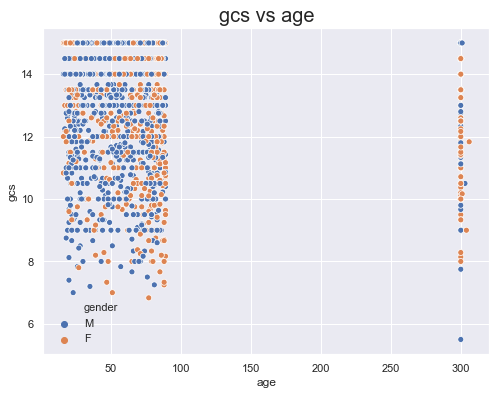

In [282]:
g =sns.scatterplot(x="age", y="gcs",
              hue="gender",
              data=data_TBI_ML.groupby(['hadm_id']).aggregate({'gender':'min', 
                                             'age':'min','gcs':'mean'})).set_title("gcs vs age", fontsize = 20)

### As we can see here, data needs to be cleaned e.g. on age

In [276]:
demographic = data_TBI_ML.groupby(['hadm_id']).aggregate({'chartdelayhrs':'mean', 'gender':'min'})
fig = px.box(demographic,x = 'gender', y="chartdelayhrs", color='gender',width=600, height=500)
fig.show()

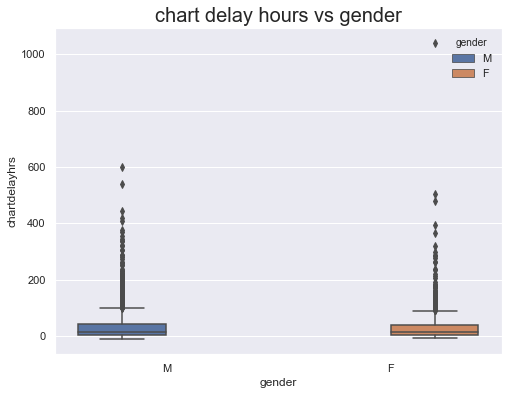

In [283]:
g =sns.boxplot(x="gender", y="chartdelayhrs",
              hue="gender",
              data=data_TBI_ML.groupby(['hadm_id']).aggregate({'chartdelayhrs':'mean', 
                                                               'gender':'min'})).set_title("chart delay hours vs gender",
                                                                                          fontsize = 20)

### we also need to get rid of some hours outliers to avoid overfit

# 2. Data Cleaning

In [284]:
#remove negative delay rows which may be caused by typo
data_TBI_ML.drop(data_TBI_ML[data_TBI_ML.chartdelayhrs <0].index, inplace=True)
#remove entries that have age >120 years old
data_TBI_ML.drop(data_TBI_ML[data_TBI_ML.age > 120].index, inplace=True)


fig = px.strip(data_TBI_ML.groupby(['hadm_id']).aggregate({'gender':'min', 'age':'min','gcs':'mean'}),
                 x="age", y="gcs", facet_col="gender", color = "gender", title = "Cleaned GCS vs Age")
fig.show()



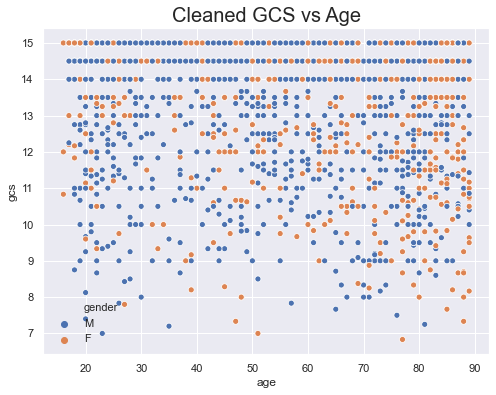

In [285]:
demographic = data_TBI_ML.groupby(['hadm_id']).aggregate({'gender':'min', 'age':'min','gcs':'mean'})
g =sns.scatterplot(x="age", y="gcs",
              hue="gender",
              data=demographic).set_title("Cleaned GCS vs Age", fontsize = 20)

In [286]:

#we also drop chart delay outliers of >200hrs
data_TBI_ML.drop(data_TBI_ML.loc[data_TBI_ML['chartdelayhrs']>200].index, inplace=True)
demographic = data_TBI_ML.groupby(['hadm_id']).aggregate({'chartdelayhrs':'mean', 'gender':'min'})
fig = px.box(demographic,x = 'gender', y="chartdelayhrs", color='gender', title = "Cleaned Delay Hours vs Gender")
fig.show()

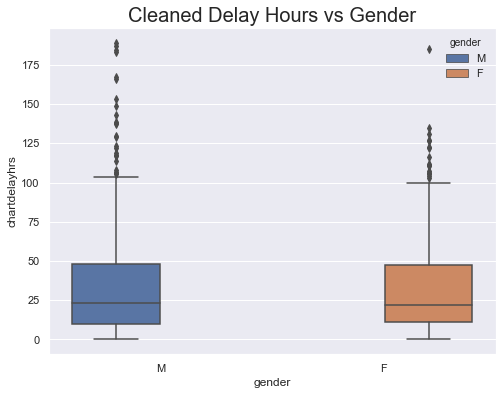

In [287]:
g =sns.boxplot(x="gender", y="chartdelayhrs",
              hue="gender",
              data=demographic).set_title("Cleaned Delay Hours vs Gender", fontsize = 20)

The Glasgow Coma Scale (GCS) classifies Traumatic Brain Injuries (TBI) as Mild (14–15); Moderate (9–13) or Severe (3–8). The ATLS modified this classification so that a GCS score of 13 is categorized as mild TBI.

In [231]:
demo1 = data_TBI_ML.groupby(['hadm_id']).aggregate({'gcs':'first', 'hospital_expire_flag':'min'}).reset_index()

#s = pd.Series(np.array([3, 9, 13, 15]), index=['Severe', 'Moderate', 'Mild' ])

demo2 = demo1.groupby(pd.cut(demo1['gcs'], 
                             bins = [2, 8, 13, 14, 15], 
                             labels = ["Severe (3-8)", "Moderate (9-13)", 
                                       "Mild (14)", "Mild (15)" ])).aggregate({'hadm_id':'count', 
                                                                                   'hospital_expire_flag':'sum'})
demo2['Mortality']=demo2['hospital_expire_flag']/demo2['hadm_id']
demo2.columns = ['Unique_Admissions', 'Deaths', 'Mortality_Rate']
# demo2.reset_index()
demo2

,Unique_Admissions,Deaths,Mortality_Rate
gcs,,,
Severe (3-8),36,10,0.277778
Moderate (9-13),173,19,0.109827
Mild (14),183,10,0.054645
Mild (15),1409,170,0.120653


Text(0.5, 1.0, 'Admission Count Share by GCS')

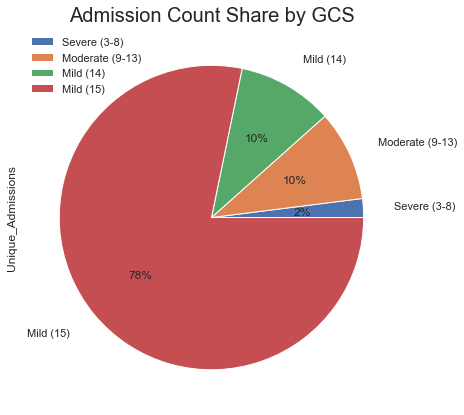

In [288]:
demo2.plot.pie(y='Unique_Admissions', 
               figsize=(10, 7), 
               autopct='%1.0f%%', 
               pctdistance=0.6, 
               labeldistance=1.2 
               ).set_title("Admission Count Share by GCS", fontsize = 20)

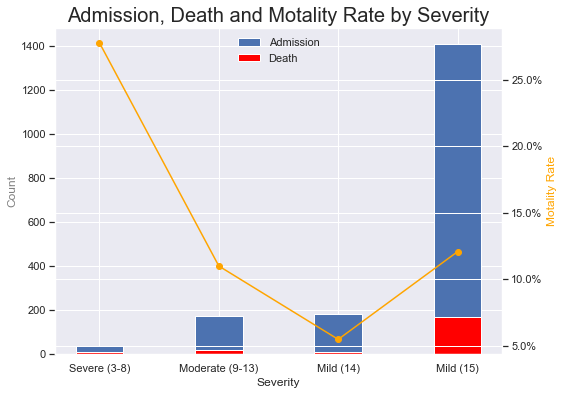

In [289]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
hAd = ax.bar(demo2.index, demo2.Unique_Admissions, width = 0.4)
hDe = ax.bar(demo2.index, demo2.Deaths,width = 0.4, color="red")
# set x-axis label
ax.set_xlabel("Severity") #,fontsize=14)
# set y-axis label
ax.set_ylabel("Count",color="grey")
ax.legend(handles =[hAd,hDe], labels =["Admission", "Death"], loc='upper center')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(demo2.index, demo2.Mortality_Rate,color="orange",marker="o")
ax2.set_ylabel("Motality Rate",color="orange")

ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Admission, Death and Motality Rate by Severity",fontsize=20)
#plt.legend()
plt.show()

# g =sns.barplot(x=demo2.index, y="Unique_Admissions",
#               data=demo2)

In [234]:
#demo2.iloc[0:4].plot(kind='bar', stacked=True)

In [235]:
#now drop hadm_id, diagnosis and icd9 before going for machine learning
data_TBI_ML.drop(columns = ['diagnosis', 'hadm_id', 'icd9_code'], inplace = True)
data_TBI_ML.head()

,gender,age,gcs,chartdelayhrs,hospital_expire_flag
0,F,81.0,15.0,5.0,0
2,F,82.0,15.0,19.0,0
5,F,82.0,14.0,19.0,0
70,F,81.0,15.0,37.0,0
117,F,81.0,14.0,5.0,0


# 3. Machine Learning on Survival

In [236]:
# This block of code was designed for handling cotegorical columns of diagnosis and icd.
# these are dropped because these happened afterfact and are of less predictable value

# data_unique is to query all unique value for categorical columns, to avoid error in imputation
# data_unique | yu (786 rows)
# data_TBI_ML -> do test_valid split (70-30)
# test (2000 rows)
# Then add data_unique back into train data, not valid data

# data_unique = pd.DataFrame()
# for i in data_TBI_ML['diagnosis'].unique():
#     criteria = "diagnosis == \"" + i +"\""
#     data_unique = pd.concat([data_unique,(data_TBI_ML.query(criteria).head(1))])
# for j in data_TBI_ML['icd9_code'].unique():
#     criteria = "icd9_code == \"" + j +"\""
#     data_unique = pd.concat([data_unique,(data_TBI_ML.query(criteria).head(1))])

# data_TBI_ML.drop(data_unique.index, inplace=True)
# data_TBI_ML.describe()

In [237]:
test = data_TBI_ML.sample(n=2000)
data_TBI_ML.drop(test.index, inplace=True)
#data_TBI_ML.describe()

data_TBI_ML.head()

,gender,age,gcs,chartdelayhrs,hospital_expire_flag
0,F,81.0,15.0,5.0,0
2,F,82.0,15.0,19.0,0
5,F,82.0,14.0,19.0,0
70,F,81.0,15.0,37.0,0
117,F,81.0,14.0,5.0,0


In [238]:
# Remove rows with missing target, separate target from predictors
from sklearn.model_selection import train_test_split
X=data_TBI_ML
y = X.hospital_expire_flag
X.drop(['hospital_expire_flag'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                      random_state=0)



In [239]:
#add unique set to the top of training set

# yu = data_unique.hospital_expire_flag
# data_unique.drop(['hospital_expire_flag'], axis=1, inplace=True)

# X_train = pd.concat([data_unique, X_train])
# y_train = pd.concat([yu, y_train])
#X_train.head()
#X_valid.head()

In [240]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
tt = test
y_test = tt.hospital_expire_flag
X_test = tt.drop(['hospital_expire_flag'], axis=1)
X_test.head()

,gender,age,gcs,chartdelayhrs
257167,M,80.0,8.0,35.0
523543,M,87.0,13.0,0.0
167247,F,32.0,15.0,11.0
485794,M,66.0,15.0,22.0
8870,M,19.0,15.0,17.0


In [241]:
from sklearn.preprocessing import LabelEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = X_test.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    label_X_test[col] = label_encoder.transform(X_test[col])

#print("MAE from Approach 2 (Label Encoding):") 
#print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

In [242]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
 # Your code here
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(label_X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(label_X_valid))
imputed_X_test = pd.DataFrame(my_imputer.transform(label_X_test))

# Imputation removed column names; put them back
imputed_X_train.columns = label_X_train.columns
imputed_X_valid.columns = label_X_valid.columns
imputed_X_test.columns = label_X_test.columns

In [243]:
# data analysis and wrangling
import numpy as np
import random as rnd

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix




# Function for comparing different approaches
from sklearn import model_selection


model = RandomForestClassifier(n_estimators=200, random_state=0)

#model = DecisionTreeClassifier()

model.fit(imputed_X_train, y_train)
preds = model.predict(imputed_X_valid)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_valid, preds.round()))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_valid, preds.round()))
print('\n')

print("=== Model Score ===")
    
print(round(model.score(imputed_X_valid, y_valid) * 100, 2))




=== Confusion Matrix ===
[[3505  157]
 [ 289  247]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3662
           1       0.61      0.46      0.53       536

    accuracy                           0.89      4198
   macro avg       0.77      0.71      0.73      4198
weighted avg       0.88      0.89      0.89      4198



=== Model Score ===
89.38


Feature: gender, 	 Score: 0.03997
Feature: age, 	 Score: 0.40197
Feature: gcs, 	 Score: 0.11655
Feature: chartdelayhrs, 	 Score: 0.44151


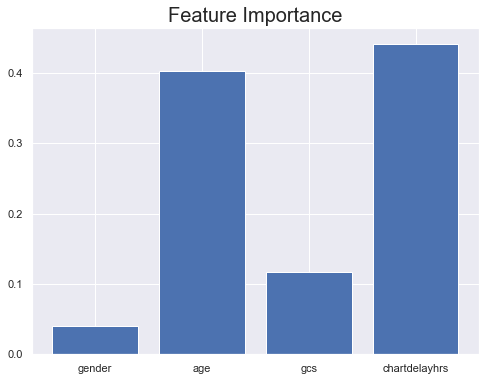

In [292]:
from matplotlib import pyplot

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0s, \t Score: %.5f' % (imputed_X_valid.columns[i],v))
# plot feature importance
pyplot.bar([imputed_X_valid.columns[x] for x in range(len(importance))], importance)
pyplot.title("Feature Importance", fontsize = 20)
pyplot.show()

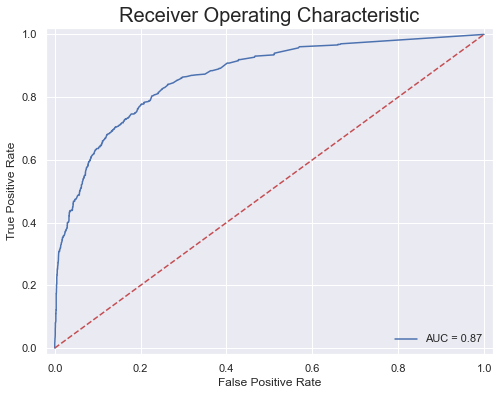

In [293]:
import scikitplot as skplt
import matplotlib.pyplot as plt



import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
y_score = model.predict_proba(imputed_X_valid)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_score)
roc_auc = metrics.auc(fpr, tpr)


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic', fontsize = 20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification


y_score = model.predict_proba(imputed_X_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()